In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,classification_report,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as utils
from torch.optim import Adam 

In [3]:
trainloader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device('cpu')

cuda


In [69]:
def call_pr_loss(a , variance):
    k = len(a[0])
    l = torch.sum(a**2)/ variance**2 /2/k
    return k/2*math.log(2*math.pi) + 0.5*k*math.log(variance) + l

In [6]:
m_200 = 1
m_784 = 1

In [50]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 200))
model.add_module('r1', nn.Sigmoid())
model.add_module('l2', nn.Linear(200, 200))
model.add_module('r2', nn.Sigmoid())


model.add_module('lf', nn.Linear(200, 10))

model.to(device)

Sequential(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (r1): Sigmoid()
  (l2): Linear(in_features=200, out_features=200, bias=True)
  (r2): Sigmoid()
  (lf): Linear(in_features=200, out_features=10, bias=True)
)

In [51]:
model.l1.weight[10][10] 

tensor(0.0013, grad_fn=<SelectBackward>)

In [52]:
def eva(test_loader , model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (test_loss ,correct / len(test_loader.dataset) )

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 5):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784)
        loss_2 = call_pr_loss(model.l2.weight , m_200)
        #loss_3 = call_pr_loss(model.l3.weight , m_200)
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200)
        
        
        loss = loss_0 + loss_1+ loss_2+  loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    scheduler.step()

Train Epoch: 1 [15984/60000 (27%)]	Loss: 1088.936035 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 1088.661133 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 1089.096191 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 1088.583252 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 1088.486206 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 1088.500122 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 1088.641602 
Train Epoch: 3 [7984/60000 (13%)]	Loss: 1088.828613 
Train Epoch: 3 [23984/60000 (40%)]	Loss: 1088.497437 
Train Epoch: 3 [39984/60000 (67%)]	Loss: 1088.530640 
Train Epoch: 3 [55984/60000 (93%)]	Loss: 1088.424072 
Train Epoch: 4 [11984/60000 (20%)]	Loss: 1088.588013 
Train Epoch: 4 [27984/60000 (47%)]	Loss: 1088.650757 
Train Epoch: 4 [43984/60000 (73%)]	Loss: 1088.586182 
Train Epoch: 4 [59984/60000 (100%)]	Loss: 1088.670654 


In [54]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0162, Accuracy: 9374/10000 (94%)



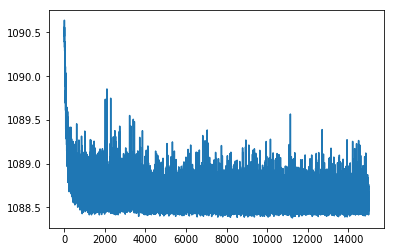

In [55]:
plt.plot(loss_history)

In [15]:
o = model.l1.weight[10][10] 

In [16]:
o

tensor(-0.0066, grad_fn=<SelectBackward>)

In [25]:
b = np.linspace(-1 , 0.1 , 20)

In [26]:
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l1.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

0

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

1

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

2

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

3

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

4

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

5

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

6

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

7

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

8

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

9

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

10

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

11

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

12

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

13

Test set: Average loss: 0.0160, Accuracy: 9383/10000 (94%)

14

Test set: Average loss: 0.0160, Accuracy: 9383/10

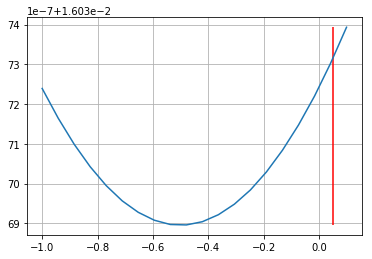

In [27]:
plt.plot(b , loss_from_t)
plt.grid()
plt.vlines(o.data , min(loss_from_t)  , max(loss_from_t) , color = 'r')

In [28]:
min(loss_from_t) -  max(loss_from_t)
#оооооочень мало

-4.974279552705241e-07

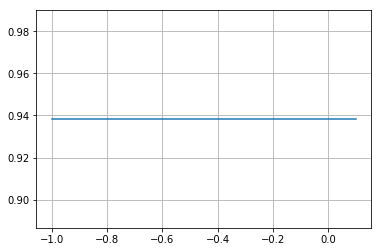

In [29]:
plt.plot(b , acc )
plt.grid()
plt.vlines(o.data , min(acc)  , max(acc) , color = 'r')

In [44]:
 model.l1.weight[10][10] = o 

In [56]:
o = model.l2.weight[10][10] 

In [57]:
o

tensor(-0.0152, grad_fn=<SelectBackward>)

In [58]:
b = np.linspace(-1 , 3 , 20)
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l2.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0162, Accuracy: 9373/10000 (94%)

0

Test set: Average loss: 0.0162, Accuracy: 9373/10000 (94%)

1

Test set: Average loss: 0.0162, Accuracy: 9372/10000 (94%)

2

Test set: Average loss: 0.0161, Accuracy: 9373/10000 (94%)

3

Test set: Average loss: 0.0161, Accuracy: 9375/10000 (94%)

4

Test set: Average loss: 0.0162, Accuracy: 9373/10000 (94%)

5

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

6

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

7

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

8

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

9

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

10

Test set: Average loss: 0.0162, Accuracy: 9376/10000 (94%)

11

Test set: Average loss: 0.0162, Accuracy: 9376/10000 (94%)

12

Test set: Average loss: 0.0162, Accuracy: 9377/10000 (94%)

13

Test set: Average loss: 0.0162, Accuracy: 9377/10000 (94%)

14

Test set: Average loss: 0.0162, Accuracy: 9376/10

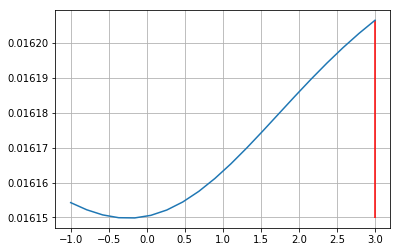

In [59]:
plt.plot(b , loss_from_t)
plt.grid()
plt.vlines(o.data , min(loss_from_t)  , max(loss_from_t) , color = 'r')

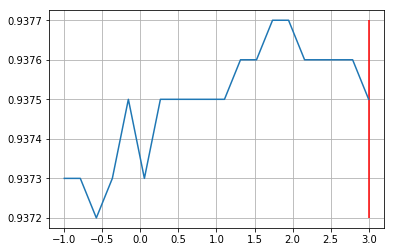

In [60]:
plt.plot(b , acc )
plt.grid()
plt.vlines(o.data , min(acc)  , max(acc) , color = 'r')

In [61]:
 model.l2.weight[10][10] = o 

In [62]:
o =  model.lf.weight[0][0]

In [63]:
o

tensor(0.1727, grad_fn=<SelectBackward>)

In [64]:
b = np.linspace(-2 , 2 , 20)
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l2.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0162, Accuracy: 9373/10000 (94%)

0

Test set: Average loss: 0.0162, Accuracy: 9374/10000 (94%)

1

Test set: Average loss: 0.0162, Accuracy: 9376/10000 (94%)

2

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

3

Test set: Average loss: 0.0162, Accuracy: 9373/10000 (94%)

4

Test set: Average loss: 0.0162, Accuracy: 9373/10000 (94%)

5

Test set: Average loss: 0.0162, Accuracy: 9372/10000 (94%)

6

Test set: Average loss: 0.0162, Accuracy: 9372/10000 (94%)

7

Test set: Average loss: 0.0161, Accuracy: 9375/10000 (94%)

8

Test set: Average loss: 0.0161, Accuracy: 9375/10000 (94%)

9

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

10

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

11

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

12

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

13

Test set: Average loss: 0.0162, Accuracy: 9375/10000 (94%)

14

Test set: Average loss: 0.0162, Accuracy: 9375/10

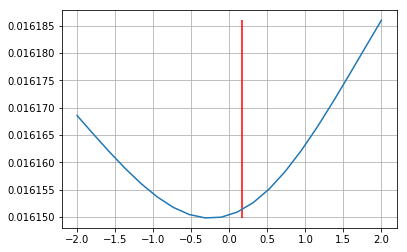

In [65]:
plt.plot(b , loss_from_t)
plt.grid()
plt.vlines(o.data , min(loss_from_t)  , max(loss_from_t) , color = 'r')

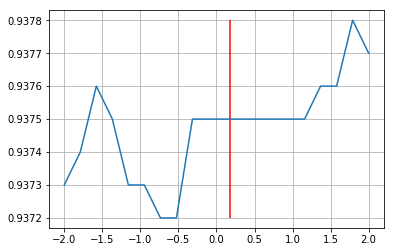

In [66]:
plt.plot(b , acc )
plt.grid()
plt.vlines(o.data, min(acc) , max(acc) , color = 'r')

# END

In [70]:
b = np.logspace(-4 ,4 , 10)

In [71]:
b

array([  1.00000000e-04,   7.74263683e-04,   5.99484250e-03,
         4.64158883e-02,   3.59381366e-01,   2.78255940e+00,
         2.15443469e+01,   1.66810054e+02,   1.29154967e+03,
         1.00000000e+04])

In [73]:
test_loss_from_var = []
accur_from_var = []
train_loss_history = []
for i in b:
    m_200 = i
    m_784 = i
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(784, 200))
    model.add_module('r1', nn.Sigmoid())
    model.add_module('l2', nn.Linear(200, 200))
    model.add_module('r2', nn.Sigmoid())
    

    model.add_module('lf', nn.Linear(200, 10))

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    model.train()
    step = 0 
    loss_history = []
    for epoch in range(1, 4):
        for batch_idx, (data, target) in enumerate(trainloader):

            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss_0 = criterion(output, target)
            loss_1 = call_pr_loss(model.l1.weight , m_784)
            loss_2 = call_pr_loss(model.l2.weight , m_200)
            #loss_3 = call_pr_loss(model.l3.weight , m_200)
            #loss_4 = call_pr_loss(model.l4.weight , m_200)
            loss_f = call_pr_loss(model.lf.weight , m_200)


            loss = loss_0 + loss_1+ loss_2 + loss_f
            loss.backward()
            optimizer.step()
            step += 1
            loss_history.append(loss.item())
            #if step % 1000  == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
            epoch, batch_idx * len(data), len(trainloader.dataset),
            100. * batch_idx / len(trainloader), loss.item()))
        #scheduler.step()  
        
        
    test_loss, accur = eva(test_loader , model)
    
    test_loss_from_var.append(test_loss)
    accur_from_var.append(accur)
    train_loss_history.append(loss_history)
    

Train Epoch: 1 [59984/60000 (100%)]	Loss: -4361.187012 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -4356.630859 
Train Epoch: 3 [59984/60000 (100%)]	Loss: -4347.611328 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: -3150.509033 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -3150.429688 
Train Epoch: 3 [59984/60000 (100%)]	Loss: -3150.302246 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: -1938.854980 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -1938.822754 
Train Epoch: 3 [59984/60000 (100%)]	Loss: -1938.868896 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: -727.193909 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -727.188965 
Train Epoch: 3 [59984/60000 (100%)]	Loss: -727.127869 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: 483.962616 
Train Epoch: 2 [59984/60000 (100%

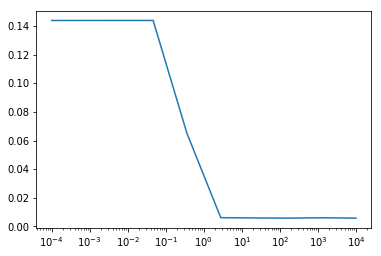

In [76]:
plt.semilogx(b , test_loss_from_var )

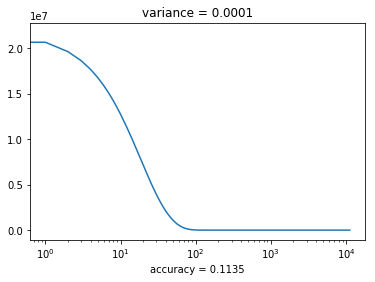

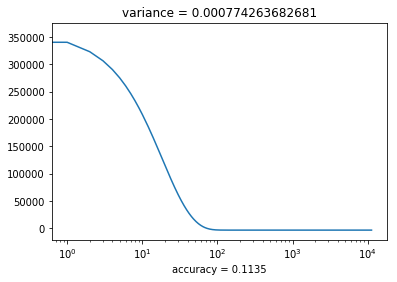

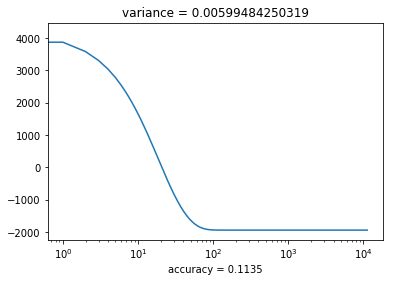

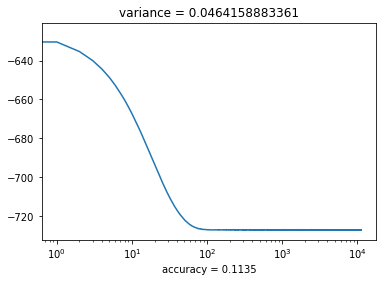

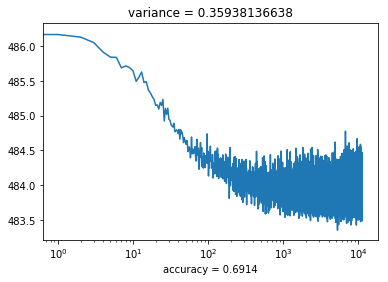

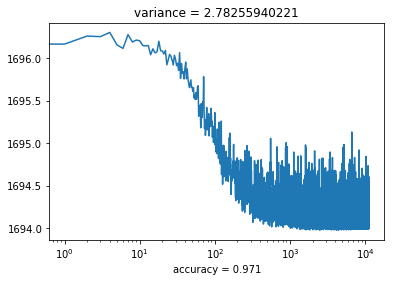

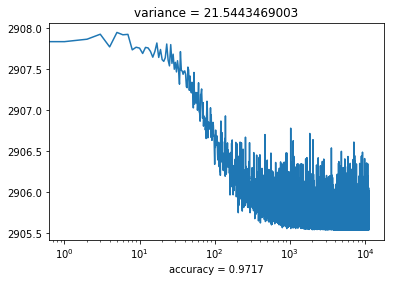

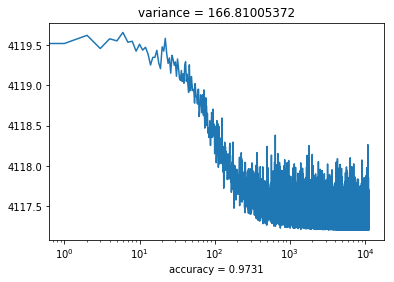

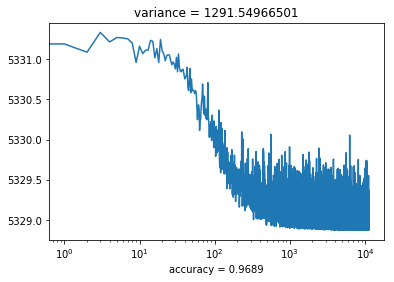

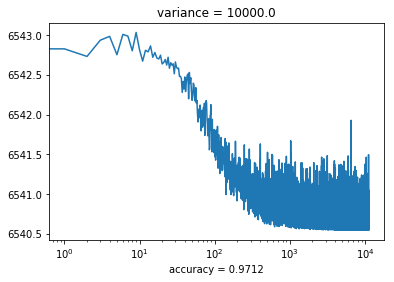

In [78]:
for i in range(len(b)):
    plt.figure()
    plt.semilogx(train_loss_history[i])
    plt.title('variance = ' + str(b[i]))
    plt.xlabel('accuracy = ' + str(accur_from_var[i]))
    plt.show()